# **DATA COLLECTING**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/Electric_Production.csv')
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


# **DATA ANALYSIS**

In [ ]:
df.shape

(397, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [ ]:
df.describe()

,Value
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [ ]:
#melihat missing values
print("\nMissing Values:")
print(df.isnull().sum())
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Missing Values:
DATE     0
Value    0
dtype: int64

Number of duplicate rows:
0


# **DATA PREPROCESSING**

In [ ]:
# Mengubah datatype date column ke datetime datatype
import pandas as pd
df['DATE'] = pd.to_datetime(df['DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [ ]:
#index date column
df.set_index('DATE', inplace=True)
df.head()


,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
#mengubah nama column 'Value' menjadi 'CONSUMPTIONS'
df = df.rename(columns = {'Value':'CONSUMPTIONS'})
df.head()

,CONSUMPTIONS
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


# **cek apakah data stasioner atau tidak**

In [ ]:
data_arima = df.copy()
data_arima.head()

,CONSUMPTIONS
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<ipython-input-77-2d7bf7a47e33>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


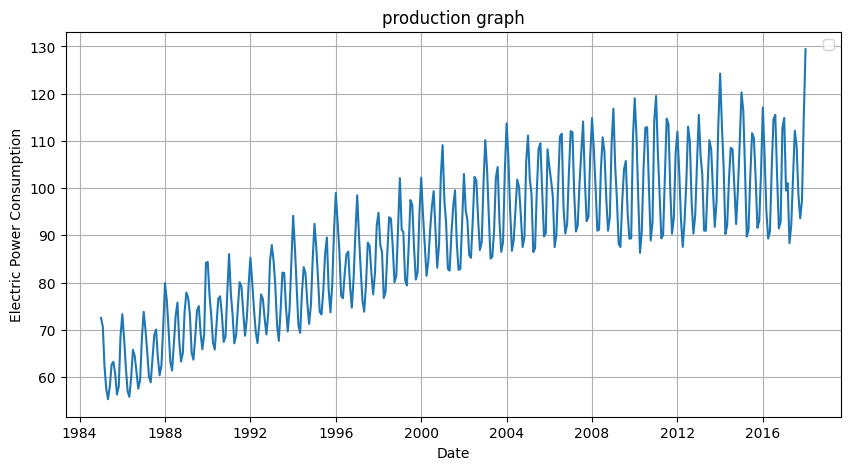

In [ ]:
# cek apakah data stasioner atau tidak
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Electric Power Consumption")
plt.title("production graph")
plt.legend()
plt.grid(True)
plt.plot(df)

Kami telah mengetahui bahwa dataset yang kami miliki belum bersifat stasioner. Agar bisa melakukan forecasting dengan lebih akurat, data tersebut perlu diubah menjadi stasioner terlebih dahulu. Pada tahap selanjutnya, kami akan mencoba mengubah data ini menjadi stasioner.

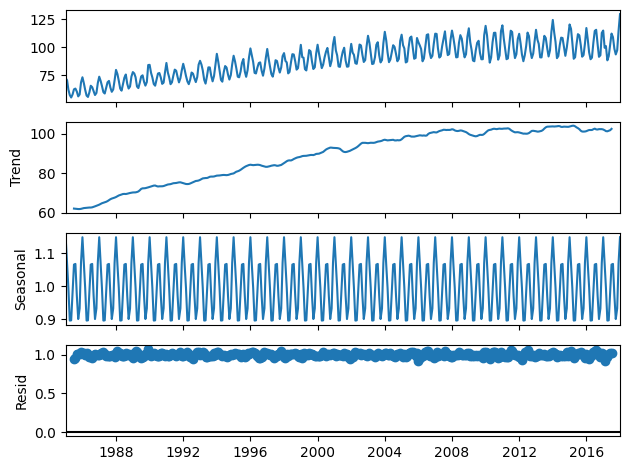

In [ ]:
#decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

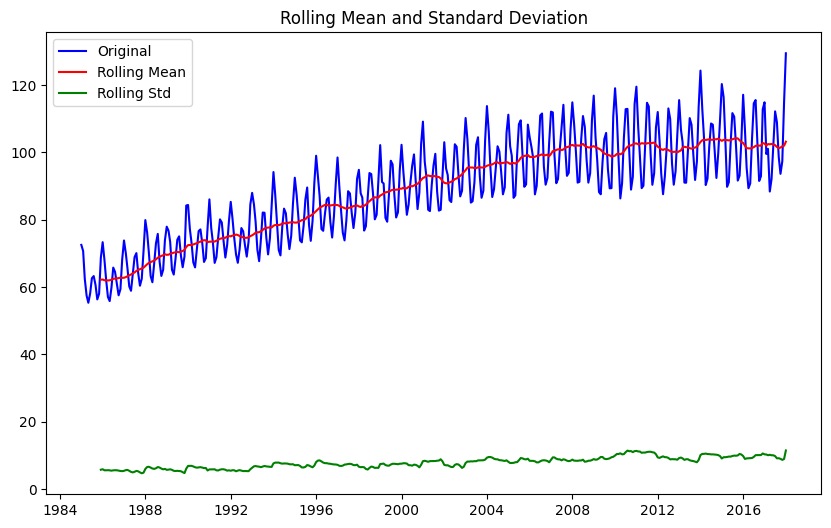

Results of ADF Test:


,0
Test Statistic,-2.256990
p-value,0.186215
#Lags Used,15.000000
Number of Observations Used,381.000000
Critical Value (1%),-3.447631
Critical Value (5%),-2.869156
Critical Value (10%),-2.570827


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Determine rolling statistics
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(10, 6))
plt.plot(df, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show()

# perform ADF test
print('Results of ADF Test:')
dickey_fuller_test = adfuller(df['CONSUMPTIONS'])
dfoutput = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dickey_fuller_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Kami melihat bahwa nilai p-value > 0,05, sehingga kita tidak bisa menolak H₀ (Null Hypothesis) yaitu Data memiliki unit root → tidak stasioner. Selain itu, nilai statistik uji juga lebih besar dari nilai kritisnya, yang menunjukkan bahwa data tersebut bersifat non-stasioner.

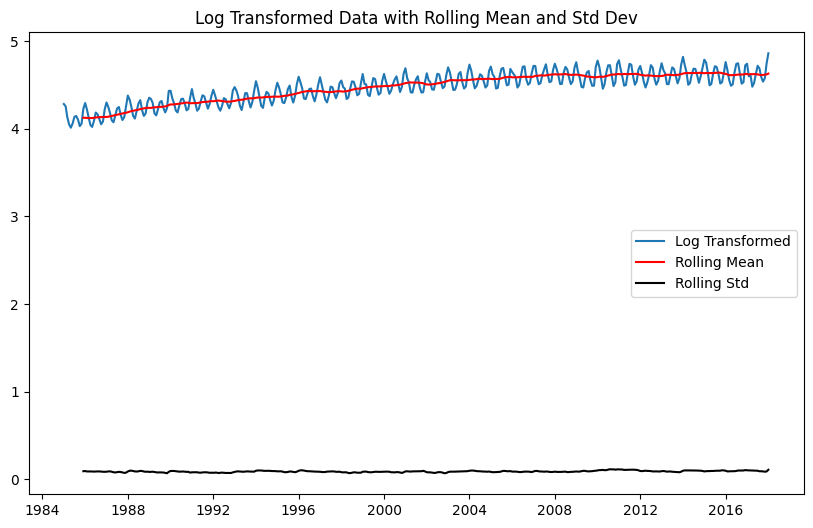

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Log Transform with Rolling Statistics
#rolling(12) -> ambil 12 data sebelumnya (termasuk titik saat ini)
df_log = np.log(data_arima)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.figure(figsize=(10, 6))
plt.plot(df_log, label='Log Transformed')
plt.plot(moving_avg, color="red", label='Rolling Mean')
plt.plot(std_dev, color ="black", label='Rolling Std')
plt.title('Log Transformed Data with Rolling Mean and Std Dev')
plt.legend()
plt.show()

In [ ]:
#Detrending with Rolling Mean after Log Transform
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

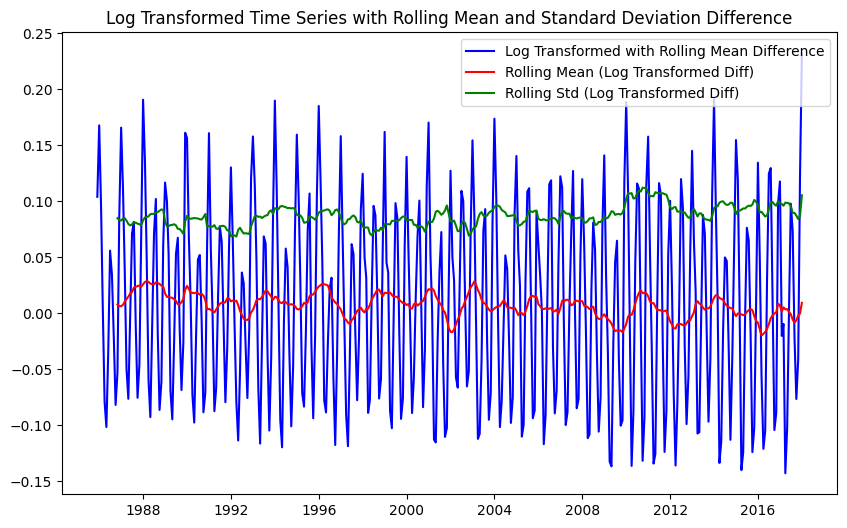

Results of ADF Test (Log Transformed):


,0
Test Statistic,-5.211586
p-value,0.000008
#Lags Used,15.000000
Number of Observations Used,370.000000
Critical Value (1%),-3.448148
Critical Value (5%),-2.869383
Critical Value (10%),-2.570948


In [ ]:
import matplotlib.pyplot as plt
# Visualize the log transformed data and rolling statistics
plt.figure(figsize=(10, 6))
plt.plot(df_log_moving_avg_diff, color='blue', label='Log Transformed with Rolling Mean Difference')
plt.plot(df_log_moving_avg_diff.rolling(12).mean(), color='red', label='Rolling Mean (Log Transformed Diff)')
plt.plot(df_log_moving_avg_diff.rolling(12).std(), color='green', label='Rolling Std (Log Transformed Diff)')
plt.legend(loc='best')
plt.title('Log Transformed Time Series with Rolling Mean and Standard Deviation Difference')
plt.show()

print('Results of ADF Test (Log Transformed):')
dickey_fuller_test_log = adfuller(df_log_moving_avg_diff['CONSUMPTIONS'])
dfoutput_log = pd.Series(dickey_fuller_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dickey_fuller_test_log[4].items():
    dfoutput_log['Critical Value (%s)'%key] = value
dfoutput_log

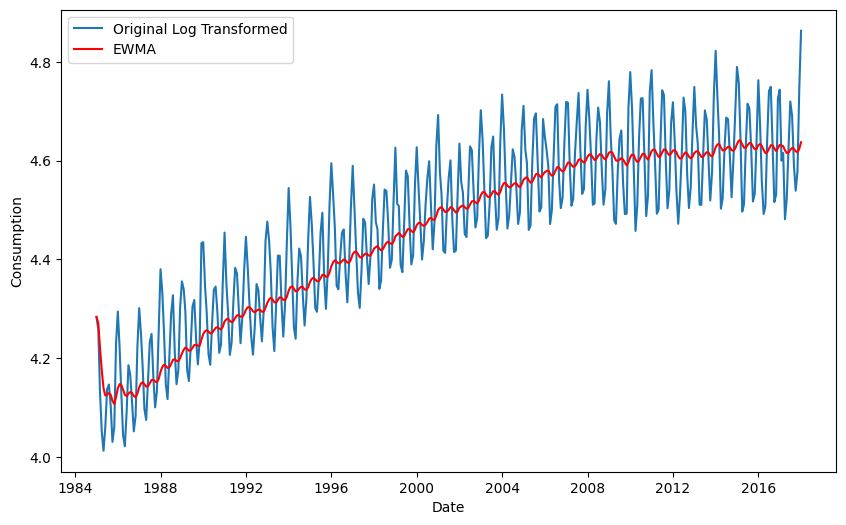

In [ ]:
#Exponential Smoothing (EWMA)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

plt.plot(df_log, label='Original Log Transformed')
plt.plot(weighted_average, color='red', label='EWMA')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
plt.legend()
plt.show(block =False)

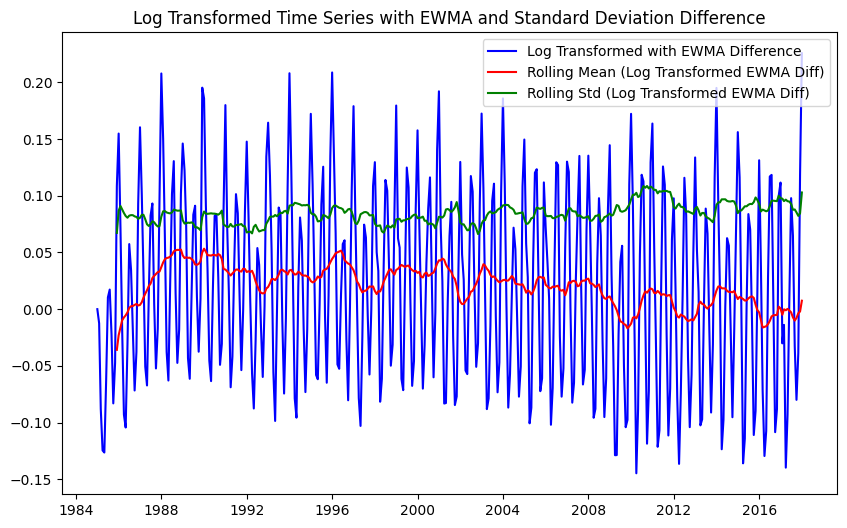

Results of ADF Test (Log Transformed with EWMA):


,0
Test Statistic,-3.251531
p-value,0.017189
#Lags Used,15.000000
Number of Observations Used,381.000000
Critical Value (1%),-3.447631
Critical Value (5%),-2.869156
Critical Value (10%),-2.570827


In [ ]:
#Detrending dengan EWMA
import pandas as pd
import matplotlib.pyplot as plt
df_ewma_diff = df_log - weighted_average
df_ewma_diff.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_ewma_diff, color='blue', label='Log Transformed with EWMA Difference')
plt.plot(df_ewma_diff.rolling(12).mean(), color='red', label='Rolling Mean (Log Transformed EWMA Diff)')
plt.plot(df_ewma_diff.rolling(12).std(), color='green', label='Rolling Std (Log Transformed EWMA Diff)')
plt.legend(loc='best')
plt.title('Log Transformed Time Series with EWMA and Standard Deviation Difference')
plt.show()


print('Results of ADF Test (Log Transformed with EWMA):')
dickey_fuller_test_ewma = adfuller(df_ewma_diff['CONSUMPTIONS'])
dfoutput_ewma = pd.Series(dickey_fuller_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dickey_fuller_test_ewma[4].items():
    dfoutput_ewma['Critical Value (%s)'%key] = value
dfoutput_ewma

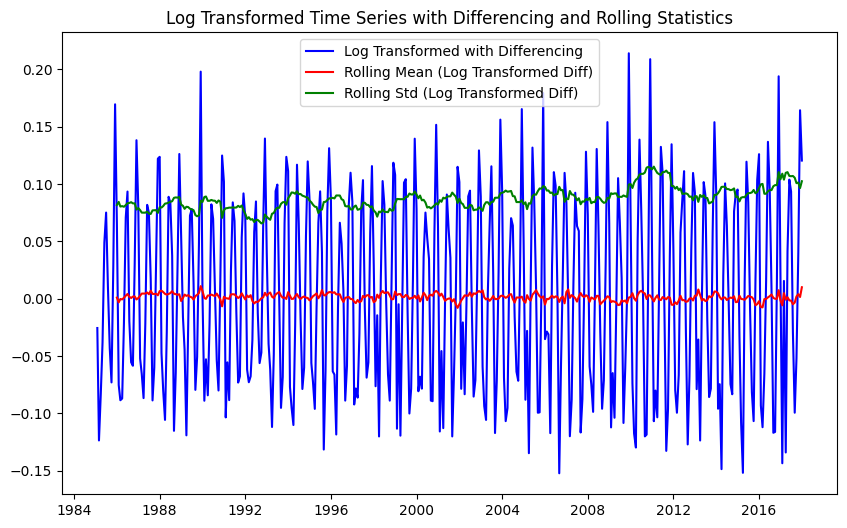

Results of ADF Test:


,0
Test Statistic,-6.748333e+00
p-value,2.995161e-09
#Lags Used,1.400000e+01
Number of Observations Used,3.810000e+02
Critical Value (1%),-3.447631e+00
Critical Value (5%),-2.869156e+00
Critical Value (10%),-2.570827e+00


In [ ]:
#Differencing
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd

df_log_diff = df_log - df_log.shift()
df_log_diff.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_log_diff, color='blue', label='Log Transformed with Differencing')
plt.plot(df_log_diff.rolling(12).mean(), color='red', label='Rolling Mean (Log Transformed Diff)')
plt.plot(df_log_diff.rolling(12).std(), color='green', label='Rolling Std (Log Transformed Diff)')
plt.legend(loc='best')
plt.title('Log Transformed Time Series with Differencing and Rolling Statistics')
plt.show()

print('Results of ADF Test:')
dickey_fuller_test = adfuller(df_log_diff.dropna())
dfoutput = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dickey_fuller_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Kami melihat bahwa nilai p-value < 0,05, sehingga kita dapat menolak H₀ (Null Hypothesis), yaitu bahwa data memiliki unit root atau tidak stasioner. Dengan kata lain, data bersifat stasioner. Selain itu, nilai statistik uji (-6.748333) juga lebih kecil dari nilai kritisnya pada tingkat signifikansi 1%, 5%, dan 10%, yang semakin menguatkan bahwa data telah memenuhi sifat stasioner

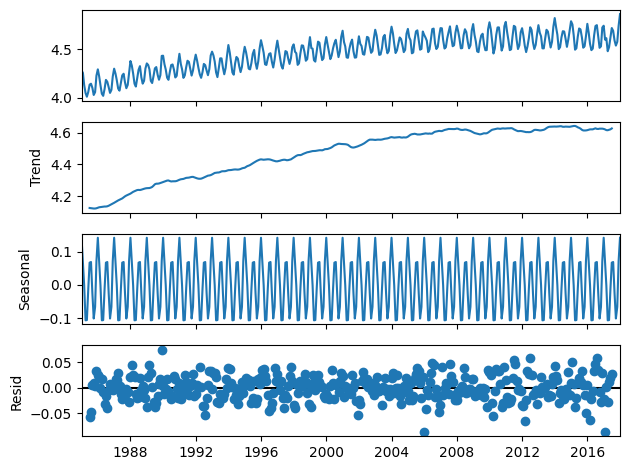

In [ ]:
#decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', period=12)
result.plot()
plt.show()

Setelah melakukan decomposition, terlihat bahwa residual menunjukkan garis yang datar dengan varians yang stabil (tidak menyebar terlalu jauh dari garis tengah), yang berarti mean dan standar deviasi-nya stabil dari waktu ke waktu. Artinya, data sudah bersifat stasioner karena tidak lagi dipengaruhi tren atau pola musiman

# **Plotting ACF & PACF**

<Figure size 1400x600 with 0 Axes>

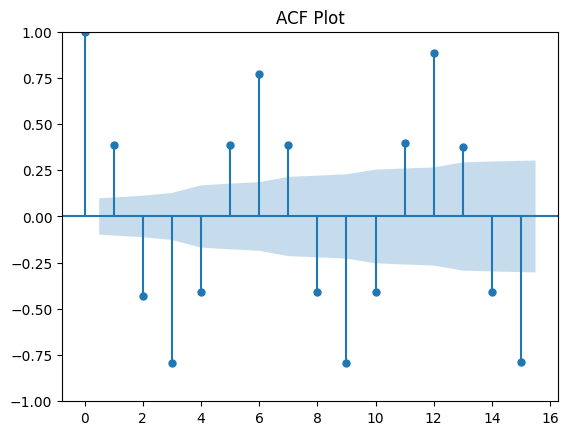

<Figure size 1400x600 with 0 Axes>

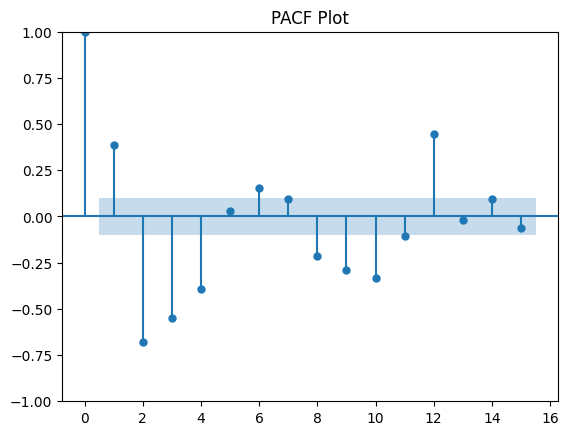

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,6))
plot_acf(df_log_diff, lags=15)
plt.title('ACF Plot')
plt.show()
plt.figure(figsize=(14,6))
plot_pacf(df_log_diff, lags=15, method='ywm')
plt.title('PACF Plot')
plt.show()

**Membagi data time series menjadi data train dan data test**

In [ ]:
import pandas as pd
last_date = data_arima.index.max()
test_start = last_date - pd.DateOffset(months=11)
test_start = test_start.replace(day=1)

# Split
train = data_arima.loc[:test_start - pd.DateOffset(days=1)]
test = data_arima.loc[test_start:]
print(f"Train data: {train.index.min()} to {train.index.max()}")
print(f"Test data: {test.index.min()} to {test.index.max()}")

Train data: 1985-01-01 00:00:00 to 2017-01-01 00:00:00
Test data: 2017-02-01 00:00:00 to 2018-01-01 00:00:00


# **ARIMA (1,1,1)**

In [ ]:
# Fit model
model = ARIMA(train['CONSUMPTIONS'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           CONSUMPTIONS   No. Observations:                  385
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1262.002
Date:                Fri, 30 May 2025   AIC                           2530.004
Time:                        03:47:43   BIC                           2541.856
Sample:                    01-01-1985   HQIC                          2534.705
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.091      0.920      0.358      -0.094       0.261
ma.L1          0.5482      0.071      7.745      0.000       0.409       0.687
sigma2        41.8405      3.199     13.079      0.0

In [ ]:
# Prediksi ke test set
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

**MODEL EVALUATION**

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Hitung MAPE
mape = mean_absolute_percentage_error(test['CONSUMPTIONS'], forecast) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 11.08%


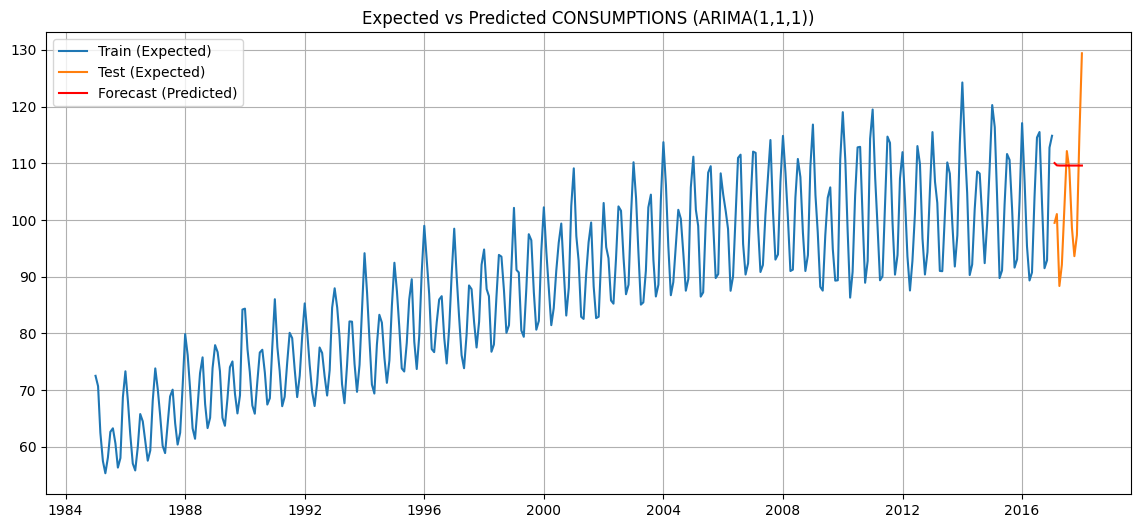

In [ ]:
import matplotlib.pyplot as plt
# Plot hasil prediksi
plt.figure(figsize=(14,6))
plt.plot(train.index, train['CONSUMPTIONS'], label='Train (Expected)')
plt.plot(test.index, test['CONSUMPTIONS'], label='Test (Expected)')
plt.plot(test.index, forecast, label='Forecast (Predicted)', color='red')
plt.legend()
plt.title(f'Expected vs Predicted CONSUMPTIONS (ARIMA(1,1,1))')
plt.grid(True)
plt.show()


# **ARIMA (2,1,3)**

In [ ]:
# Fit model
model = ARIMA(train['CONSUMPTIONS'], order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           CONSUMPTIONS   No. Observations:                  385
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -995.973
Date:                Fri, 30 May 2025   AIC                           2003.945
Time:                        03:48:06   BIC                           2027.649
Sample:                    01-01-1985   HQIC                          2013.347
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    517.263      0.000       0.996       1.004
ar.L2         -0.9997      0.001  -1422.047      0.000      -1.001      -0.998
ma.L1         -1.2179      0.054    -22.740      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Prediksi ke test set
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

**MODEL EVALUATION**

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Hitung MAPE
mape = mean_absolute_percentage_error(test['CONSUMPTIONS'], forecast) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 4.63%


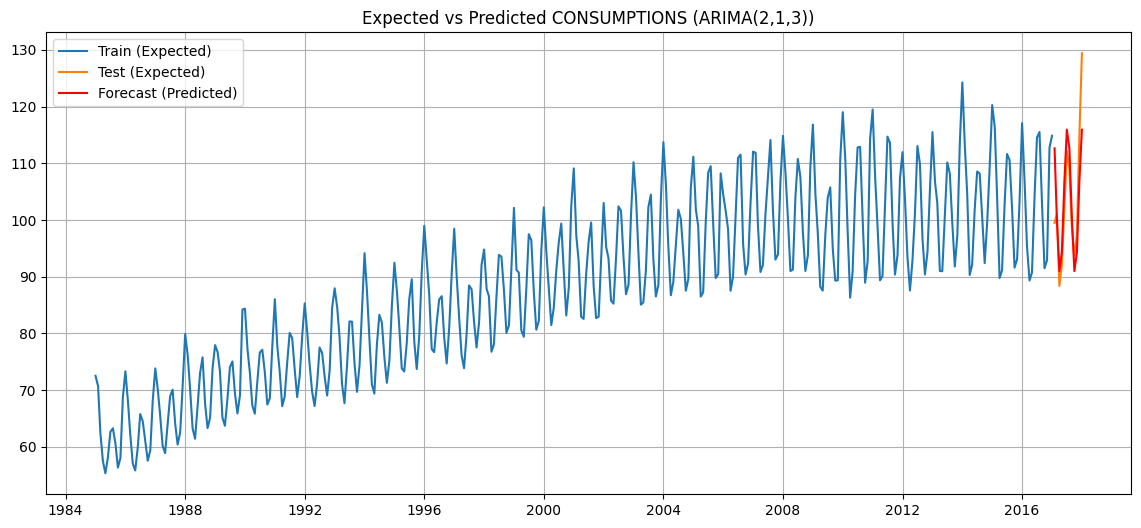

In [ ]:
import matplotlib.pyplot as plt
# Plot hasil prediksi
plt.figure(figsize=(14,6))
plt.plot(train.index, train['CONSUMPTIONS'], label='Train (Expected)')
plt.plot(test.index, test['CONSUMPTIONS'], label='Test (Expected)')
plt.plot(test.index, forecast, label='Forecast (Predicted)', color='red')
plt.legend()
plt.title(f'Expected vs Predicted CONSUMPTIONS (ARIMA(2,1,3))')
plt.grid(True)
plt.show()